In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,Flatten, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

2025-08-13 04:47:23.295712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755060443.605765      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755060443.694492      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
 df = pd.read_csv("/kaggle/input/traffic-flow-data/traffic.csv")

df.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [4]:
df = df.drop(['ID'], axis=1)

df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [5]:
data = df.copy()

Text(0.5, 0, 'Date')

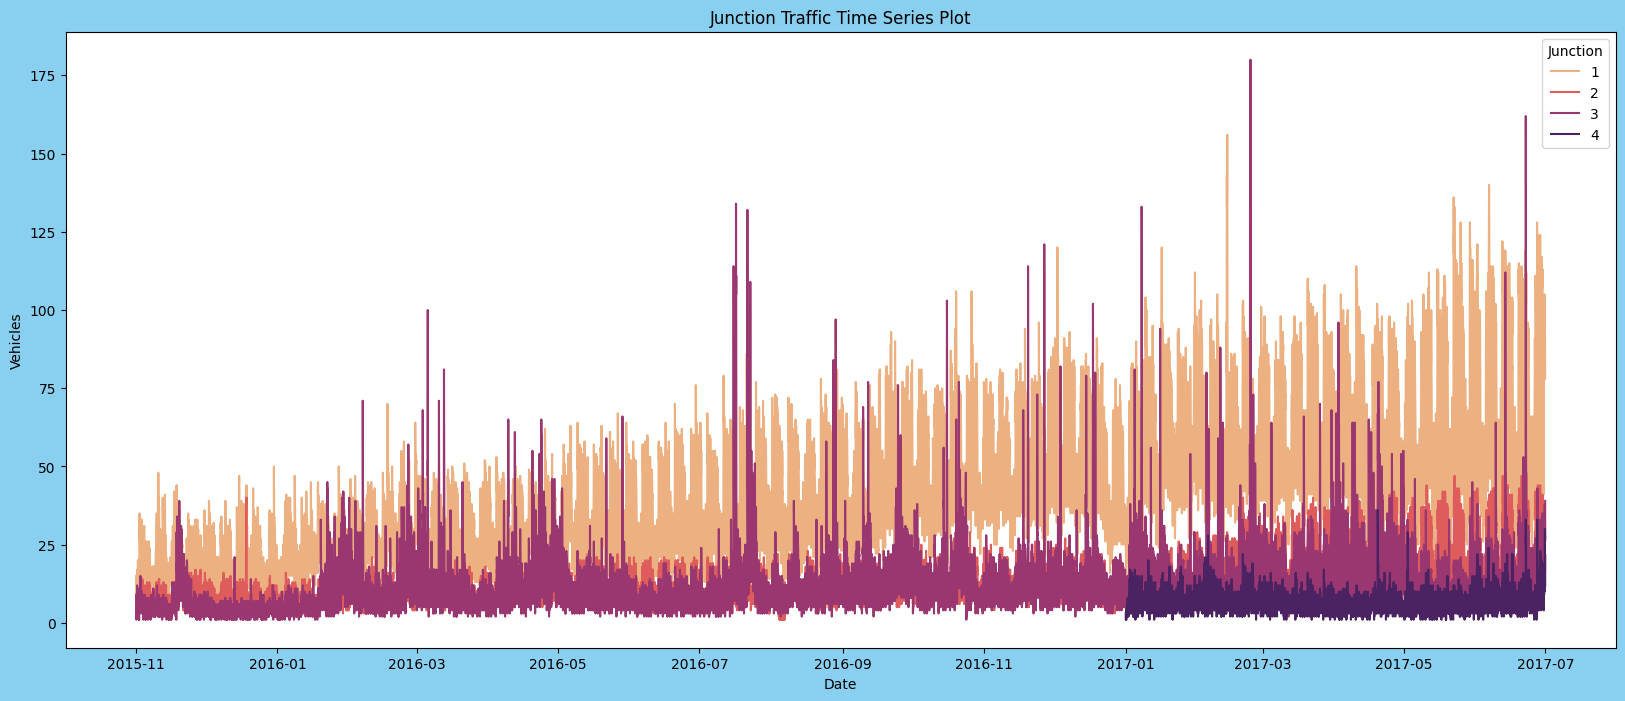

In [6]:
plt.figure(figsize=(20,8), facecolor="#89CFF0")

t_series = sns.lineplot(x=data['DateTime'], y='Vehicles', data=data, hue='Junction', palette='flare')
t_series.set_title("Junction Traffic Time Series Plot")
t_series.set_ylabel('Vehicles')
t_series.set_xlabel('Date')

In [7]:
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Date'] = data['DateTime'].dt.date
data['Hour'] =  data['DateTime'].dt.hour

data['Day'] = data.DateTime.dt.strftime('%A')

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,2015-11-01,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,2015-11-01,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,2015-11-01,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,2015-11-01,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,2015-11-01,4,Sunday


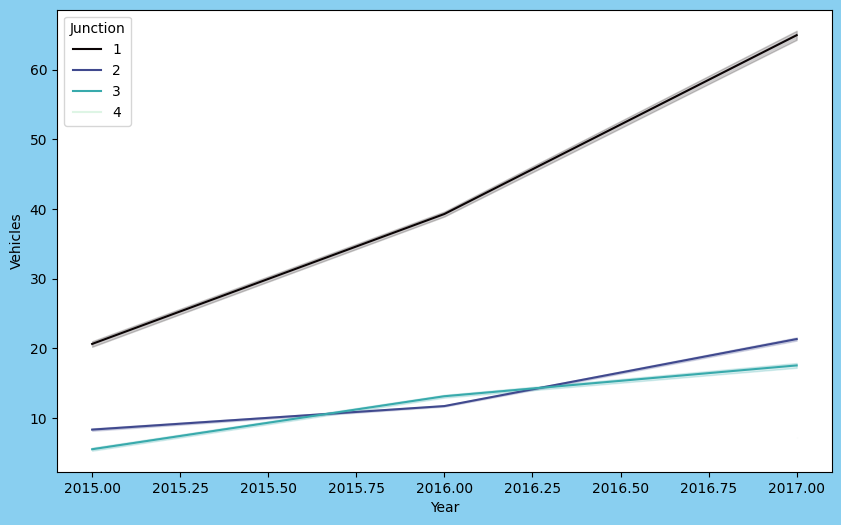

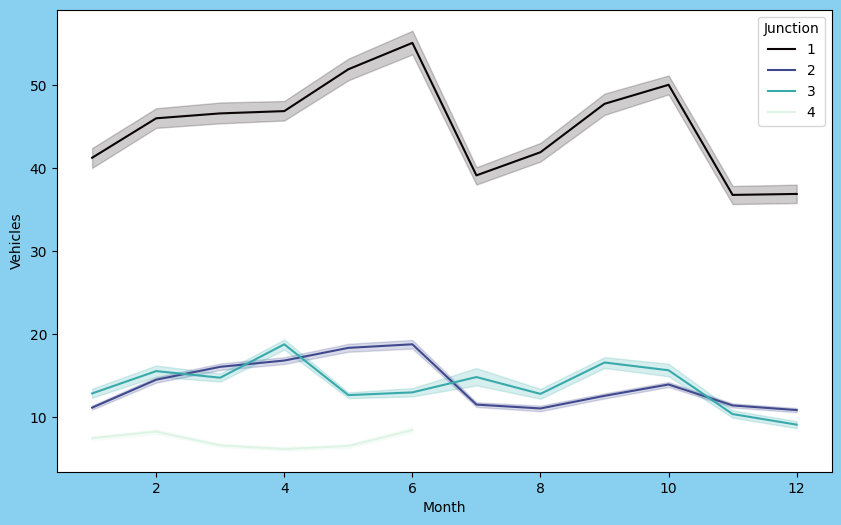

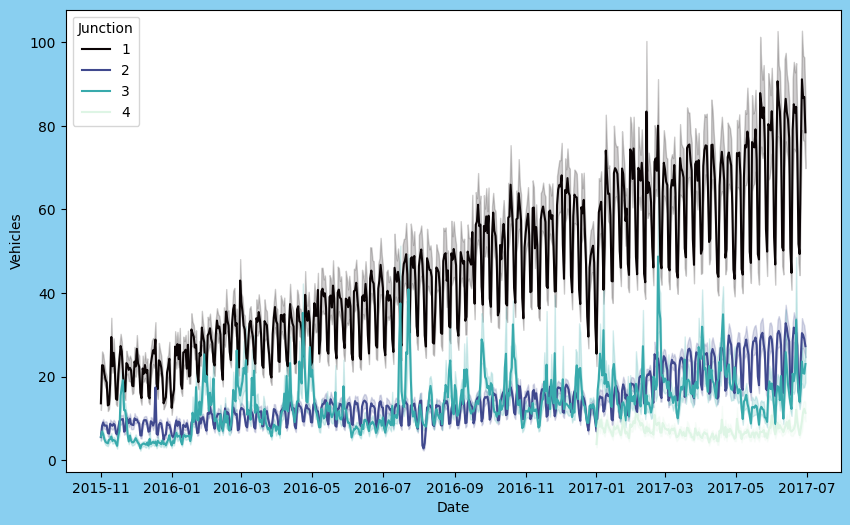

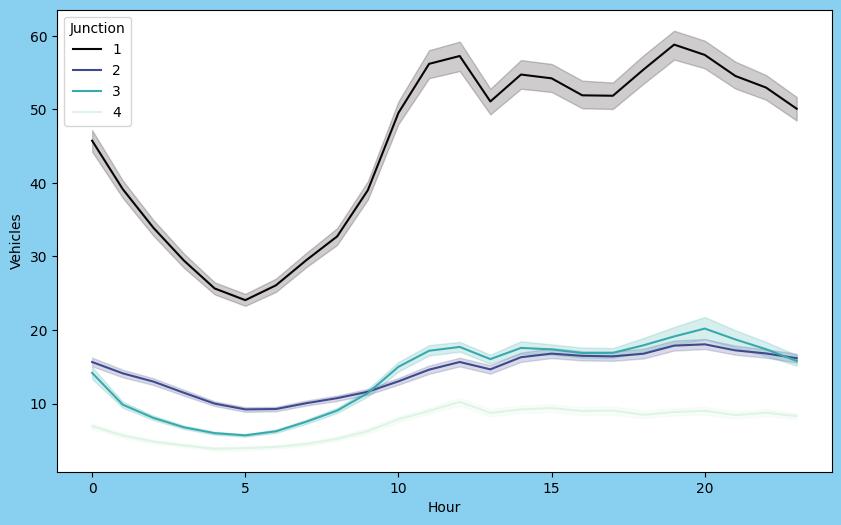

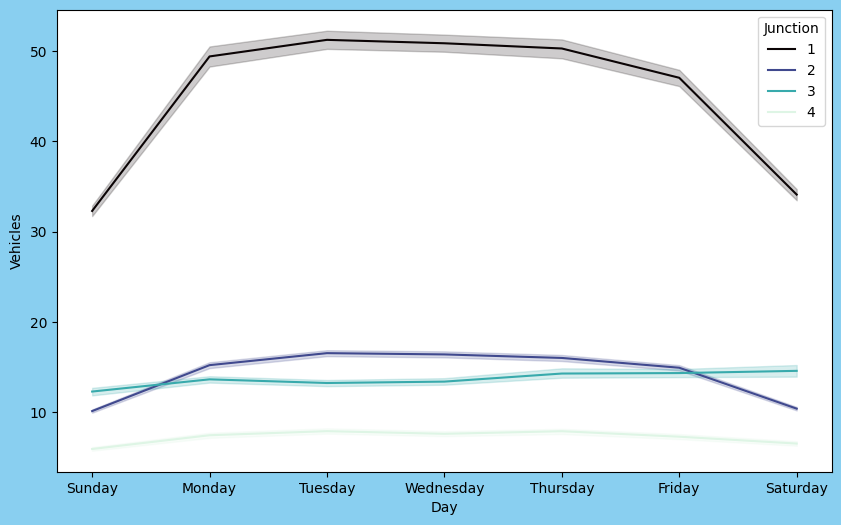

In [8]:
new_features = ['Year', 'Month', 'Date', 'Hour', 'Day']

for i in new_features:
    plt.figure(figsize=(10,6), facecolor='#89CFF0')
    ax = sns.lineplot(x=data[i], y='Vehicles', data=data, hue='Junction', palette='mako')

Text(0.5, 0, 'Date')

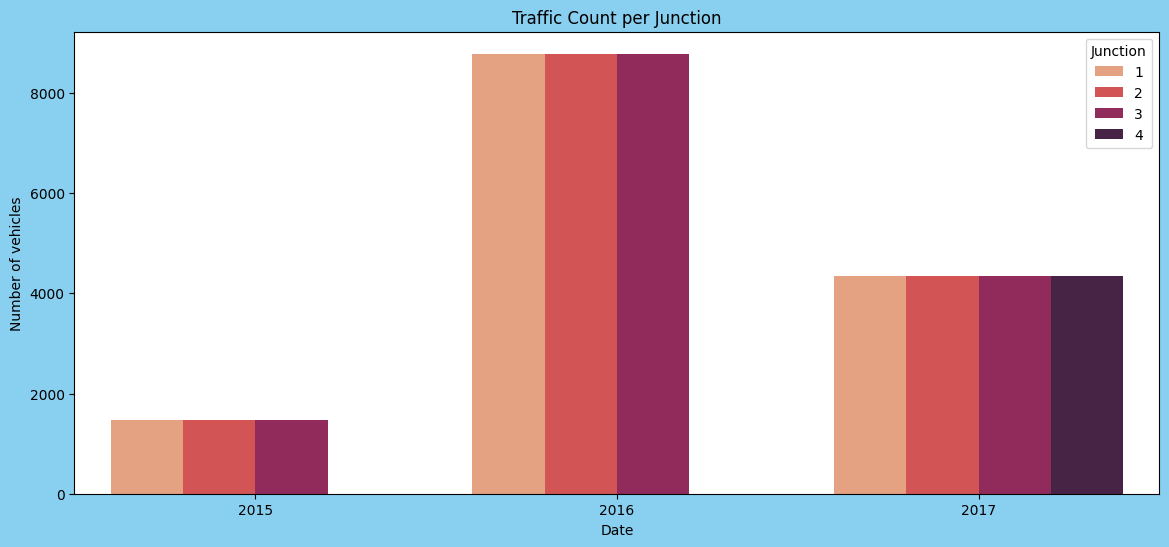

In [9]:
plt.figure(figsize=(14,6), facecolor='#89CFF0')

count = sns.countplot(data=data, x=data['Year'], hue='Junction', palette='rocket_r')

count.set_title('Traffic Count per Junction')
count.set_ylabel("Number of vehicles")
count.set_xlabel("Date")


<Figure size 1400x600 with 0 Axes>

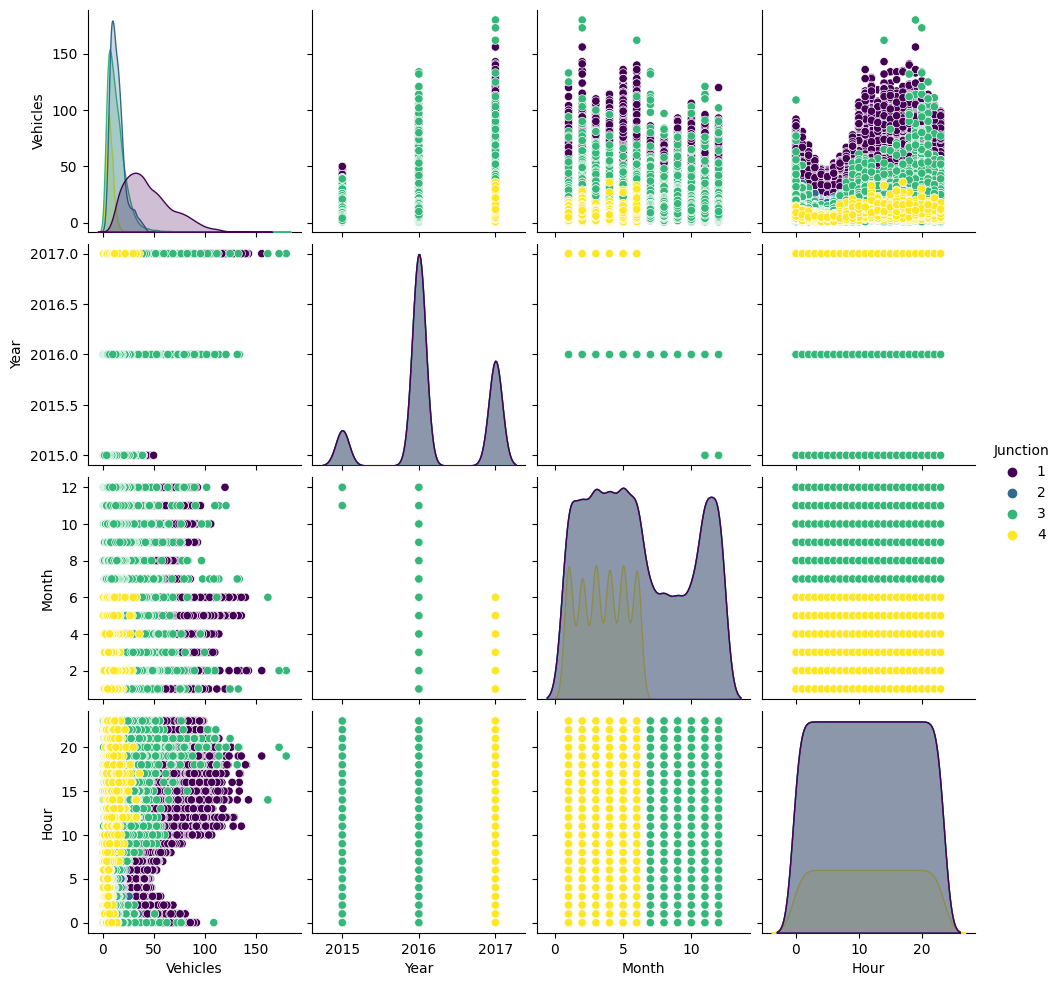

In [10]:
plt.figure(figsize=(14,6), facecolor='#89CFF0')

sns.pairplot(data=data, hue='Junction', palette='viridis')

In [11]:
df_junction = df.pivot(columns='Junction', index='DateTime')

df_junction.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [12]:
df_j1 = df_junction[[('Vehicles', 1)]]
df_j2 = df_junction[[('Vehicles', 2)]]
df_j3 = df_junction[[('Vehicles', 3)]]
df_j4 = df_junction[[('Vehicles', 4)]]

df_j4 = df_j4.dropna()

In [13]:
list_df = [df_j1, df_j2, df_j3, df_j4]

#for i in list_df:
    #i.columns = i.columns.droplevel(level=0)

def sub_plots_4(df_j1, df_j2, df_j3, df_j4, title):
    fig, axes  = plt.subplots(4,1, figsize=(15,8), facecolor='#89CFF0', sharey=True)
    fig.suptitle(title)
    
    plot_1 = sns.lineplot(ax=axes[0], data=df_j1, color='black')
    axes[0].set(ylabel='Junction 1')
   
    plot_2 = sns.lineplot(ax=axes[1], data=df_j2, color='orange')
    axes[1].set(ylabel='Junction 2')
    
    plot_3 = sns.lineplot(ax=axes[2], data=df_j3, color='purple')
    axes[2].set(ylabel='Junction 3')
    
    plot_4 =  sns.lineplot(ax=axes[3], data=df_j4, color='pink')
    axes[3].set(ylabel='Junction 4')

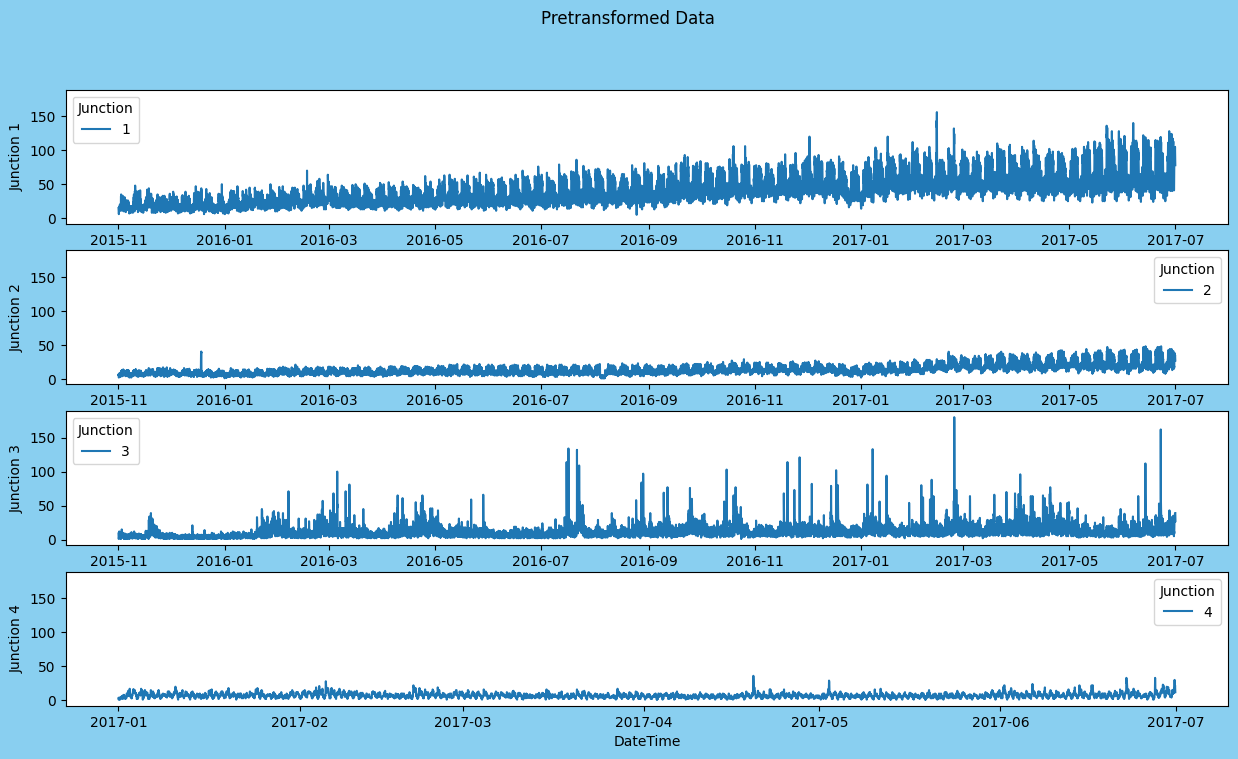

In [14]:
sub_plots_4(df_j1.Vehicles, df_j2.Vehicles, df_j3.Vehicles, df_j4.Vehicles, "Pretransformed Data")

In [15]:
def df_normalization(df,col):
    average = df[col].mean()
    std_dev = df[col].stdev()
    
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    
    return df_normalized, average, std_dev
    

In [16]:
def differencing(df, col, interval):
    diff = []
    
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)

    return diff